<a href="https://colab.research.google.com/github/eduzegarra/grade_01/blob/main/proyecto_papa_v02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyecto Papa Sostenible: Integración, Limpieza y Análisis Exploratorio**


Librerías externas necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## **1. Lectura, limpieza e integración de base de datos**

### 1.1. Lectura de base de datos original en Excel

Leemos primer libro del archivo Excel (volumen) asignado a objeto "vol" (en este caso subimos primero el archivo al entorno para leerlo)

In [ ]:
vol = pd.read_excel('/content/sample_data/base_completa_1997_2021.xls', sheet_name='volumen')

In [ ]:
vol

In [ ]:
vol.columns

In [ ]:
vol.shape

In [ ]:
vol.isna().sum()

Cambiamos nombres de variables de meses para consistencia

In [7]:
vol.rename(columns={'m_1':'m_01','m_2':'m_02','m_3':'m_03','m_4':'m_04','m_5':'m_05','m_6':'m_06',
                    'm_7':'m_07','m_8':'m_08', 'm_9':'m_09'}, inplace=True)

Notar opción "inplace=True" implica que se cambia la base de datos "vol" con los nuevos nombres de las variables

Leemos segundo libro (precios) del archivo excel y asignamos a objeto "pre"

In [9]:
pre = pd.read_excel('/content/sample_data/base_completa_1997_2021.xls', sheet_name='precio')

In [ ]:
pre.shape

In [ ]:
pre.columns

In [ ]:
pre.isna().sum()

In [13]:
pre.rename(columns={'m_1':'m_01','m_2':'m_02','m_3':'m_03','m_4':'m_04','m_5':'m_05','m_6':'m_06',
                    'm_7':'m_07','m_8':'m_08', 'm_9':'m_09'}, inplace=True)

Las columnas 'Variable' y 'producto' identifican a la provincia y la variedad, cambiamos los nombres

In [15]:
vol.rename(columns={'Variable':'provincia', 'producto': 'variedad'}, inplace=True)

In [17]:
pre.rename(columns={'producto':'variedad'}, inplace=True)

Las columnas m_01 a m_12 denotan meses. Necesitamos convertir al mes como una variable, para tener en cada fila una observacion, pasar base en formato ancho a largo (wide to long) usando el método **melt**

In [18]:
vol_long=pd.melt(vol,id_vars=['variedad','year','provincia'], 
                var_name='mes', value_name='volumen')

Lo mismo con la base de precios

In [20]:
pre_long=pd.melt(pre,id_vars=['variedad','year'], 
                var_name='mes', value_name='precio')

### 1.2. Limpieza datos originales

Damos una mirada a cada una de estas bases de datos

primero el asunto de los valores "missing" (sin información)

In [ ]:
vol_long.isna().groupby(vol_long.year)['volumen'].sum().plot()
plt.title('Observaciones missing in base volumen')

In [ ]:
pre_long.isna().groupby(pre_long.year)['precio'].sum().plot()
plt.title('Observacione smissing in base precios')

Eliminamos observaciones con valores missing (NaN) en ambas bases

In [25]:
pre_long.dropna(inplace=True)
vol_long.dropna(inplace=True)

In [ ]:
vol_long.isna().sum()

In [ ]:
pre_long.isna().sum()

### 1.3. Evolución de variables y número de observaciones

In [ ]:
pre_long.groupby(pre_long.year)['precio'].mean().plot()
plt.title('Evolución de precio promedio')

In [ ]:
vol_long.groupby(vol_long.year)['volumen'].sum().plot.bar()
plt.title('Evolución de volumen promedio')

In [ ]:
vol_long.groupby(vol_long.year).agg({'provincia':'nunique', 'variedad':'nunique', 'mes':['nunique','count']})

In [ ]:
plt.figure(figsize=(9,5))
vol_long.groupby(vol_long.year)['volumen'].count().plot()
plt.xticks(np.arange(1997,2022,1),rotation=45, fontsize='small')
plt.yticks(np.arange(0,1600,200))
plt.title('Número de observaciones por año de volumen', fontsize='xx-large')
plt.xlabel('')
plt.show()

In [ ]:
pre_long.groupby(pre_long.year).agg({'variedad':'nunique', 'mes':['nunique','count']})

In [ ]:
plt.figure(figsize=(9,5))
pre_long.groupby(pre_long.year)['precio'].count().plot()
rr=np.arange(1997,2022,1)
plt.xticks(rr,rotation=45, fontsize='small')
plt.yticks(np.arange(20,150,20))
plt.title('Número de observaciones por año en base precios', fontsize='xx-large')
plt.show()

### 1.4. Merge de archivos

Bases 'vol_long' y 'pre_long' tienen una estructura similar y variables en comun y pueden ser integradas (usando método **merge**, con parámetro 'inner')

In [38]:
df_base=vol_long.merge(pre_long, on=['variedad','year','mes'], how='inner')

In [ ]:
df_base.shape

In [ ]:
df_base.columns

In [ ]:
df_base.describe(include='all')

En objeto generado como **df_base** en cada fila tenemos una observación que identifica la variedad, el año, la provincia, el mes así como el volumen y precio

Notar que la variable precio corresponde a la variedad y mes, pero no varía por provincia de origen (el precio se forma en MML)

Se pueden generar subconjuntos de la base de datos utilizando varios métodos y condiciones

In [42]:
huanuco=df_base[df_base.provincia=='Huanuco']

In [ ]:
huanuco

In [ ]:
df_base[df_base.provincia.isin(['Huanuco'])]

In [ ]:
hh='Huanuco'
df_base.query('provincia==@hh')

In [ ]:
df_base.query('`precio` >= 1.5 and `precio` <= 2.5')

Podemos borrar el objeto 'huanuco' usando 'del'

In [71]:
del huanuco

Creamos variable 'ym' que identifica año y mes por observacion

In [72]:
df_base['ym']=df_base['year'].astype(str)+df_base['mes']

Esto sirve para ordenar la base por fecha (mes)

In [ ]:
df_base.sort_values('ym', ascending=True)

Resumen: la base creada 'df_base' (integrada) ha pasado por un primer proceso de limpieza y ordenamiento.
    
    (i) convertimos bases en formato ancho a largo
    
    (ii) eliminamos valores NaN en bases de volumen y precios
    
    (iii) juntamos bases de volumen y precios
    
    (iv) cambiamos algunos nombres de variables

In [ ]:
df_base.describe(include='all')

Esta es una primera base "limpia" y "ordenada" con la que se puede iniciar el análisis exploratorio.

Tiene 21,333 observaciones con valores para precios y volúmenes de 11 variedades de papa

## **2. Primer análisis exploratorio**

## 2.1. Mirada general


Vemos a las variedades en sus diferencias. Esto requiere 'agrupar' las bases por variedad.  El método groupby es central para este proceso.

In [ ]:
df_base.groupby(df_base['variedad'])['volumen'].sum().sort_values(ascending=False)

In [ ]:
df_base.groupby(df_base['variedad'])['precio'].mean().sort_values(ascending=False)

In [ ]:
df_base.groupby(df_base['variedad']).agg({'volumen':['count','mean', 'min','max'],'precio':['mean','min','max'], 'year':['min','max'], 'provincia':'nunique'})

In [ ]:
df_base.groupby(df_base['variedad']).agg({'provincia':'nunique'}).plot.bar()

## 2.2.  Dinámica de oferta y precios por variedad

Observar la dinámica de las variables en tiempo es muy importante.  Podemos agrupar los datos por año y visualizar

### Papa Blanca

In [ ]:
plt.figure(figsize=(8,5))
vol_blanca=df_base[['year','volumen']][df_base.variedad=="Papa Blanca"].groupby('year').sum()
plt.bar(vol_blanca.index,vol_blanca.volumen)
plt.title("Papa Blanca: Volumen", fontsize='xx-large')
plt.xticks(vol_blanca.index,rotation=45, fontsize='small')
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
pre_blanca=df_base[['year','precio']][df_base.variedad=="Papa Blanca"].groupby('year').mean()
plt.plot(pre_blanca.index,pre_blanca.precio)
plt.title("Papa Blanca: Precio", fontsize='xx-large')
plt.xticks(pre_blanca.index,rotation=45, fontsize='small')
plt.show()

### Papa Yungay

In [ ]:
plt.figure(figsize=(8,5))
vol_yungay=df_base[['year','volumen']][df_base.variedad=="Papa Yungay"].groupby('year').sum()
plt.bar(vol_yungay.index,vol_yungay.volumen)
plt.title("Papa Yungay: Volumen", fontsize='xx-large')
plt.xticks(vol_blanca.index,rotation=45, fontsize='small')
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
pre_yungay=df_base[['year','precio']][df_base.variedad=="Papa Yungay"].groupby('year').mean()
plt.plot(pre_yungay.index,pre_yungay.precio)
plt.title("Papa Yungay: Precio", fontsize='xx-large')
plt.xticks(pre_blanca.index,rotation=45, fontsize='small')
plt.yticks(np.arange(0.1,1.7,.1))
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
pre_yungay=df_base[['year','precio']][df_base.variedad=="Papa Yungay"].groupby('year').mean()
plt.plot(pre_yungay.index,pre_yungay.precio)
plt.plot(pre_blanca.index,pre_blanca.precio)
plt.title("Papa Blanca y Yungay: Precio", fontsize='xx-large')
plt.xticks(pre_blanca.index,rotation=45, fontsize='small')
plt.yticks(np.arange(0.1,1.7,.1))
plt.show()

### Papa Huayro

In [ ]:
plt.figure(figsize=(8,5))
vol_huayro=df_base[['year','volumen']][df_base.variedad=="Papa Huayro"].groupby('year').sum()
plt.bar(vol_huayro.index,vol_huayro.volumen)
plt.title("Papa Huayro: Volumen")
plt.xticks(vol_huayro.index,rotation=45, fontsize='small')
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
pre_huayro=df_base[['year','precio']][df_base.variedad=="Papa Huayro"].groupby('year').mean()
plt.plot(pre_huayro.index,pre_huayro.precio)
plt.title("Papa Huayro: Precio", fontsize='xx-large')
plt.xticks(pre_huayro.index,rotation=45, fontsize='small')
plt.yticks(np.arange(0.1,1.7,.2))
plt.show()

### Papa Canchan

In [ ]:
plt.figure(figsize=(8,5))
vol_canchan=df_base[['year','volumen']][df_base.variedad=="Papa Canchan"].groupby('year').sum()
plt.bar(vol_canchan.index,vol_canchan.volumen)
plt.title("Papa Canchan: Volumen", fontsize='xx-large')
plt.xticks(vol_blanca.index,rotation=45, fontsize='small')
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
pre_canchan=df_base[['year','precio']][df_base.variedad=="Papa Canchan"].groupby('year').mean()
plt.plot(pre_canchan.index,pre_canchan.precio)
plt.title("Papa Canchan: Precio", fontsize='xx-large')
plt.xticks(pre_blanca.index,rotation=45, fontsize='small')
plt.yticks(np.arange(.1,1.7,.2))
plt.show()

### Papa Amarilla

In [ ]:
plt.figure(figsize=(8,5))
vol_amarilla=df_base[['year','volumen']][df_base.variedad=="Papa Amarilla"].groupby('year').sum()
plt.bar(vol_amarilla.index,vol_amarilla.volumen)
plt.title("Papa Amarilla: Volumen", fontsize='xx-large')
plt.xticks(vol_amarilla.index,rotation=45, fontsize='small')
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
pre_amarilla=df_base[['year','precio']][df_base.variedad=="Papa Amarilla"].groupby('year').mean()
plt.plot(pre_amarilla.index,pre_amarilla.precio)
plt.title("Papa Amarilla: Precio", fontsize='xx-large')
plt.xticks(pre_amarilla.index,rotation=45, fontsize='small')
plt.yticks(np.arange(.1,2.4,.2))
plt.show()

### Papa Color

In [ ]:
plt.figure(figsize=(8,5))
vol_color=df_base[['year','volumen']][df_base.variedad=="Papa Color"].groupby('year').sum()
plt.bar(vol_color.index,vol_color.volumen)
plt.title("Papa Color: Volumen", fontsize='xx-large')
plt.xticks(vol_color.index,rotation=45, fontsize='small')
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
pre_color=df_base[['year','precio']][df_base.variedad=="Papa Color"].groupby('year').mean()
plt.plot(pre_color.index,pre_color.precio)
plt.title("Papa Color: Precio", fontsize='xx-large')
plt.xticks(pre_color.index,rotation=45, fontsize='small')
plt.yticks(np.arange(.1,1.6,.2))
plt.show()

### Papa Unica

In [ ]:
plt.figure(figsize=(8,5))
vol_unica=df_base[['year','volumen']][df_base.variedad=="Papa Unica"].groupby('year').sum()
plt.bar(vol_unica.index,vol_unica.volumen)
plt.title("Papa Unica: Volumen", fontsize='xx-large')
plt.xticks(vol_color.index,rotation=45, fontsize='small')
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
pre_unica=df_base[['year','precio']][df_base.variedad=="Papa Unica"].groupby('year').mean()
plt.plot(pre_unica.index,pre_unica.precio)
plt.title("Papa Unica: Precio", fontsize='xx-large')
plt.xticks(pre_color.index,rotation=45, fontsize='small')
plt.yticks(np.arange(.1,1.6,.2))
plt.show()

### Papa Peruanita

In [ ]:
plt.figure(figsize=(8,5))
vol_peruanita=df_base[['year','volumen']][df_base.variedad=="Papa Peruanita"].groupby('year').sum()
plt.bar(vol_peruanita.index,vol_peruanita.volumen)
plt.title("Papa Peruanita: Volumen", fontsize='xx-large')
plt.xticks(vol_color.index,rotation=45, fontsize='small')
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
pre_peruanita=df_base[['year','precio']][df_base.variedad=="Papa Peruanita"].groupby('year').mean()
plt.plot(pre_peruanita.index,pre_peruanita.precio)
plt.title("Papa Peruanita: Precio", fontsize='xx-large')
plt.xticks(pre_color.index,rotation=45, fontsize='small')
plt.yticks(np.arange(.1,2.4,.2))
plt.show()

### Papa Perricholi

In [ ]:
plt.figure(figsize=(8,5))
vol_perricholi=df_base[['year','volumen']][df_base.variedad=="Papa Perricholi"].groupby('year').sum()
plt.bar(vol_perricholi.index,vol_perricholi.volumen)
plt.title("Papa Perricholi: Volumen", fontsize='xx-large')
plt.xticks(vol_color.index,rotation=45, fontsize='small')
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
pre_perricholi=df_base[['year','precio']][df_base.variedad=="Papa Perricholi"].groupby('year').mean()
plt.plot(pre_perricholi.index,pre_perricholi.precio)
plt.title("Papa Perricholi: Precio", fontsize='xx-large')
plt.xticks(pre_color.index,rotation=45, fontsize='small')
plt.yticks(np.arange(.1,1.6,.2))
plt.show()

### Papa Huamantanga

In [ ]:
plt.figure(figsize=(8,5))
vol_huamantanga=df_base[['year','volumen']][df_base.variedad=="Papa Huamantanga"].groupby('year').sum()
plt.bar(vol_huamantanga.index,vol_huamantanga.volumen)
plt.title("Papa Huamantanga: Volumen", fontsize='xx-large')
plt.xticks(vol_color.index,rotation=45, fontsize='small')
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
pre_huamantanga=df_base[['year','precio']][df_base.variedad=="Papa Huamantanga"].groupby('year').mean()
plt.plot(pre_huamantanga.index,pre_huamantanga.precio)
plt.title("Papa Huamantanga: Precio", fontsize='xx-large')
plt.xticks(pre_color.index,rotation=45, fontsize='small')
plt.yticks(np.arange(.1,2.4,.2))
plt.show()

### Papa Negra Andina

In [ ]:
plt.figure(figsize=(8,5))
vol_negra=df_base[['year','volumen']][df_base.variedad=="Papa Negra Andina"].groupby('year').sum()
plt.bar(vol_negra.index,vol_negra.volumen)
plt.title("Papa Negra Andina: Volumen", fontsize='xx-large')
plt.xticks(vol_color.index,rotation=45, fontsize='small')
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
pre_negra=df_base[['year','precio']][df_base.variedad=="Papa Negra Andina"].groupby('year').mean()
plt.plot(pre_negra.index,pre_negra.precio)
plt.title("Papa Negra Andina: Precio", fontsize='xx-large')
plt.xticks(pre_color.index,rotation=45, fontsize='small')
plt.yticks(np.arange(.1,1.8,.2))
plt.show()

### Papas con precios similares a Papa Blanca

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(pre_yungay.index,pre_yungay.precio,label='Yungay')
plt.plot(pre_blanca.index,pre_blanca.precio, label='Blanca')
plt.plot(pre_canchan.index,pre_canchan.precio, label='Canchan')
plt.plot(pre_color.index,pre_color.precio, label='Color')
plt.plot(pre_perricholi.index,pre_perricholi.precio, label='Perricholi')
plt.title("Papa Blanca, Yungay, Canchan, Color, Perricholi: Precio", fontsize='large')
plt.xticks(pre_blanca.index,rotation=45, fontsize='small')
plt.legend()
plt.show()

### Papas con precios similares a papa amarilla

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(pre_amarilla.index,pre_amarilla.precio, label='Amarilla')
plt.plot(pre_peruanita.index,pre_peruanita.precio, label='Peruanita')
plt.plot(pre_huamantanga.index,pre_huamantanga.precio, label='Huamantanga')
plt.title("Papa Amarilla, Peruanita, Huamantanga", fontsize='large')
plt.xticks(pre_blanca.index,rotation=45, fontsize='small')
plt.legend()
plt.show()

### Precios de huayro y negra andina

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(pre_huayro.index,pre_huayro.precio, label='Huayro')
plt.plot(pre_negra.index,pre_negra.precio, label='Negra Andina')
plt.title("Papa Huayro, Negra Andina", fontsize='large')
plt.xticks(pre_blanca.index,rotation=45, fontsize='small')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(pre_blanca.index,pre_blanca.precio, label='Blanca', color='gray')
plt.plot(pre_amarilla.index,pre_amarilla.precio, label='Amarilla')
plt.plot(pre_huayro.index,pre_huayro.precio, label='Huayro')
plt.title("Papa Blanca, Amarilla y Huayro", fontsize='x-large')
plt.xticks(pre_blanca.index,rotation=45, fontsize='small')
plt.legend()
plt.show()

## 2.3. Análisis de las provincias de origen y su peso en la producción

Creamos variable de valor (precio*volumen) para cada observación. Esta variable está en millones de soles

In [85]:
df_base['valor']=(df_base['volumen']*df_base['precio'])/1000

In [ ]:
df_base.valor.describe()

In [87]:
vv_valor=pd.DataFrame(df_base.groupby('year')['valor'].sum())


In [ ]:
plt.figure(figsize=(8,5))
plt.bar(vv_valor.index,vv_valor.valor)
plt.suptitle("Valor de transacciones de Papa 1997-2020",fontsize='x-large')
plt.title("Millones de soles")
plt.xticks(vv_valor.index,rotation=45, fontsize='small')
plt.show()

Generamos ranking de provincias de acuerdo a valor total de papa enviada a Lima entre 1997 y mayo 2021

In [89]:
rank_prov=df_base.groupby(df_base.provincia)['valor'].sum()

In [90]:
prov_19=rank_prov.sort_values(ascending=False)[0:19].sum()

In [93]:
prov_resto=rank_prov.sort_values(ascending=False)[19:len(rank_prov)].sum()

In [ ]:
prov_19/(prov_19+prov_resto)


Las primeras 19 provincias del ranking generan el 96.4% del valor total de la papa enviada a Lima. Tiene sentido acotar la base solamente a esas 19 provincias para analizar el mercado de papas en general (pero ojo con variedades específicas donde pocas provincias son importantes como Negra Andina o Huamantanga)

In [98]:
r19=rank_prov.sort_values(ascending=False)[0:19]

In [ ]:
r19.sort_values(ascending=False)

In [ ]:
r19

In [101]:
df_base2=df_base[df_base["provincia"].isin(r19.index)]

In [ ]:
df_base2.provincia.value_counts()

## 2.4. Análisis por región natural de origen

Creamos variable 'costa' que identifica provincias de la costa

In [ ]:
df_base2['costa']=df_base2['provincia'].isin(['Huaral','Lima','Barranca',
                'Nazca','Canete','Huaura','Arequipa','Ica']).astype('int')

Peso de cada región en valor de producción por variedad

In [109]:
v_costa=df_base2[df_base2['costa']==1].groupby('variedad')['valor'].sum()
v_sierra=df_base2[df_base2['costa']==0].groupby('variedad')['valor'].sum()
v_total=v_costa+v_sierra
r_sierra=(v_sierra/v_total)*100

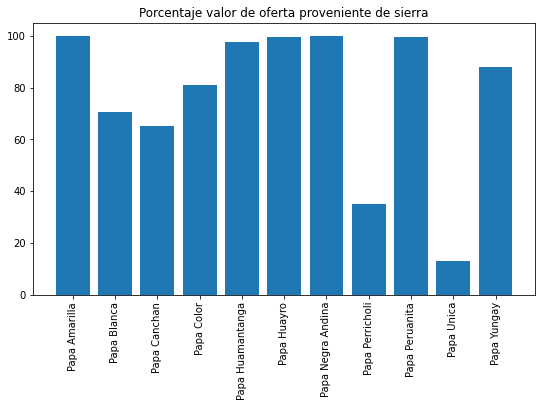

In [114]:
plt.figure(figsize=(9,5))
plt.bar(r_sierra.index,r_sierra)
plt.xticks(rotation=90)
plt.title("Porcentaje valor de oferta proveniente de sierra")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

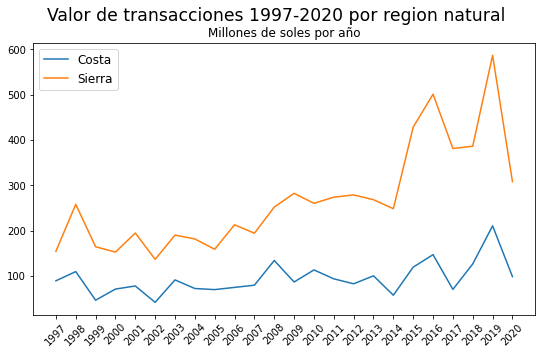

In [115]:
plt.figure(figsize=(9,5))
ll_costa=df_base2[(df_base2.costa==1) & (df_base2.year<=2020)].groupby('year')['valor'].sum()
ll_sierra=df_base2[(df_base2.costa==0) & (df_base2.year<=2020)].groupby('year')['valor'].sum()
plt.plot(ll_costa.index, ll_costa, label='Costa')
plt.plot(ll_sierra.index, ll_sierra, label='Sierra')
plt.legend(fontsize='large')
plt.suptitle('Valor de transacciones 1997-2020 por region natural', fontsize='xx-large')
plt.title('Millones de soles por año')
plt.xticks(ll_costa.index, rotation=45)
plt.show

In [120]:
kk_costa=ll_costa/(ll_costa+ll_sierra)*100

Text(0.5, 1.0, 'Participación de costa en valor de producción')

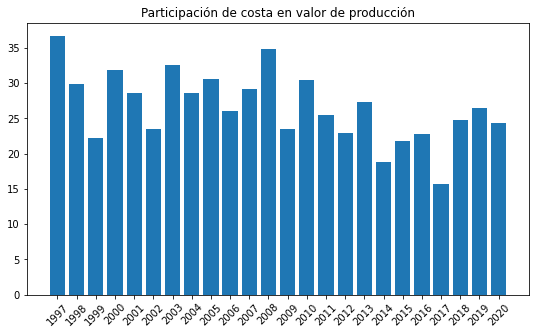

In [129]:
plt.figure(figsize=(9,5))
plt.bar(kk_costa.index, kk_costa)
plt.xticks(np.arange(1997,2021,1), rotation=45)
plt.title("Participación de costa en valor de producción")

<function matplotlib.pyplot.show(close=None, block=None)>

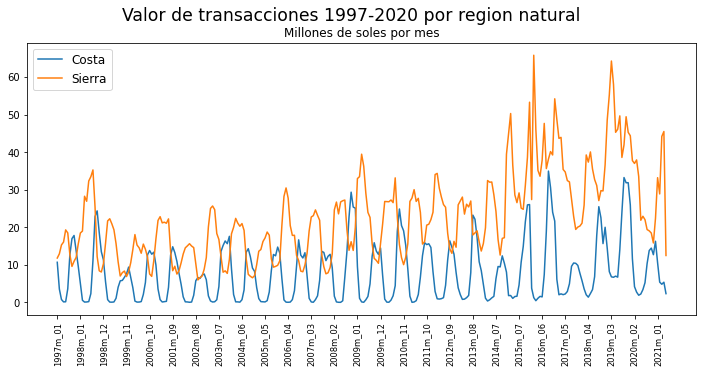

In [130]:
plt.figure(figsize=(12,5))
mm_costa=df_base2[df_base2.costa==1].groupby('ym')['valor'].sum()
mm_sierra=df_base2[df_base2.costa==0].groupby('ym')['valor'].sum()
plt.plot(mm_costa.index, mm_costa, label='Costa')
plt.plot(mm_sierra.index, mm_sierra, label='Sierra')
plt.legend(fontsize='large')
plt.suptitle('Valor de transacciones 1997-2020 por region natural', fontsize='xx-large')
plt.title('Millones de soles por mes')
rr=mm_costa.index[np.arange(0,len(mm_costa),11)]
plt.xticks(rr, rotation=90, fontsize='small')
plt.show

La base **df_base2** puede ser utilizada para el modelamiento y análisis del mercado de papa (en sus distintas variedades) de Lima Metropolitana.

In [131]:
df_base2.describe(include='all')

,variedad,year,provincia,mes,volumen,precio,ym,valor,costa
count,15549,15549.000000,15549,15549,15549.000000,15549.000000,15549,15549.000000,15549.000000
unique,11,NaN,19,12,NaN,NaN,291,NaN,NaN
top,Papa Blanca,NaN,Huancayo,m_08,NaN,NaN,2018m_08,NaN,NaN
freq,4838,NaN,1397,1455,NaN,NaN,112,NaN,NaN
mean,NaN,2011.149849,NaN,NaN,760.478341,0.902209,NaN,0.573689,0.292302
std,NaN,7.110863,NaN,NaN,1613.421424,0.439640,NaN,1.212714,0.454835
min,NaN,1997.000000,NaN,NaN,0.090000,0.280000,NaN,0.000065,0.000000
25%,NaN,2005.000000,NaN,NaN,29.000000,0.610000,NaN,0.025000,0.000000
50%,NaN,2013.000000,NaN,NaN,127.860000,0.770000,NaN,0.108778,0.000000
75%,NaN,2017.000000,NaN,NaN,651.920000,1.090000,NaN,0.509960,1.000000


Tenemos 15,549 observaciones en la base final, 11 variedades, 19 provincias, 291 meses

In [132]:
df_base2.variedad.value_counts()

Papa Blanca          4838
Papa Color           4012
Papa Amarilla        2018
Papa Yungay          1215
Papa Canchan         1045
Papa Unica            806
Papa Huayro           717
Papa Peruanita        371
Papa Perricholi       339
Papa Negra Andina     131
Papa Huamantanga       57
Name: variedad, dtype: int64

In [ ]:
df_base2.to_excel('/content/sample_data/df_base2.xlsx')